In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, f1_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import time

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import nltk
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer

import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

In [2]:
df = pd.read_csv('../data/brands_and_product_tweets.csv')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [4]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [6]:
# Dropped rows with "I can't tell" value
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

In [7]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [8]:
sw = stopwords.words('english')
new_sw = ['sxsw','link', 'rt']
sw.extend(new_sw)
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
# pattern to grab words with 3 characters or more
lemmer = WordNetLemmatizer()
#p_stemmer = PorterStemmer()
#s_stemmer = SnowballStemmer()

Define a function so that inputted text is lower cased, tokenized, stop words removed, & lemmed.

In [9]:
#def pre_text(text, tokenizer, sw, lemmer):
#    text_lower = text.lower()
#    tokens = tokenizer.tokenize(text_lower)
#    tokens_filtered = [token for token in tokens if token not in sw]
#    tokens_lemmed = [lemmer.lemmatize(token) for token in tokens]

In [10]:
def clean_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return ''  # Return empty string if text is not a string
    # Remove URLs items
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    #stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in sw])
    
    return text

# Clean the tweet_text column
#df['cleaned_tweet_text'] = df['tweet_text'].apply(clean_text)

In [11]:
# Function to lemmatize text
def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize each word
    lemmatized_tokens = [lemmer.lemmatize(token) for token in tokens]
    # Rejoin lemmatized tokens into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Example text
example_text = "Fall Out Boy Rules."

# Lemmatize the example text
lemmatized_text = lemmatize_text(example_text)
print(lemmatized_text)

Fall Out Boy Rules .


In [12]:
df['cleaned_text'] = df['tweet_text'].apply(clean_text)

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,g iphone hrs tweeting rise austin dead need up...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year's festival crashy year's iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri marissa mayer google tim o'rei...


In [13]:
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_text,lemmatized_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,g iphone hrs tweeting rise austin dead need up...,g iphone hr tweeting rise austin dead need upg...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad also sale,wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year's festival crashy year's iphone app,hope year 's festival crashy year 's iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri marissa mayer google tim o'rei...,great stuff fri marissa mayer google tim o'rei...


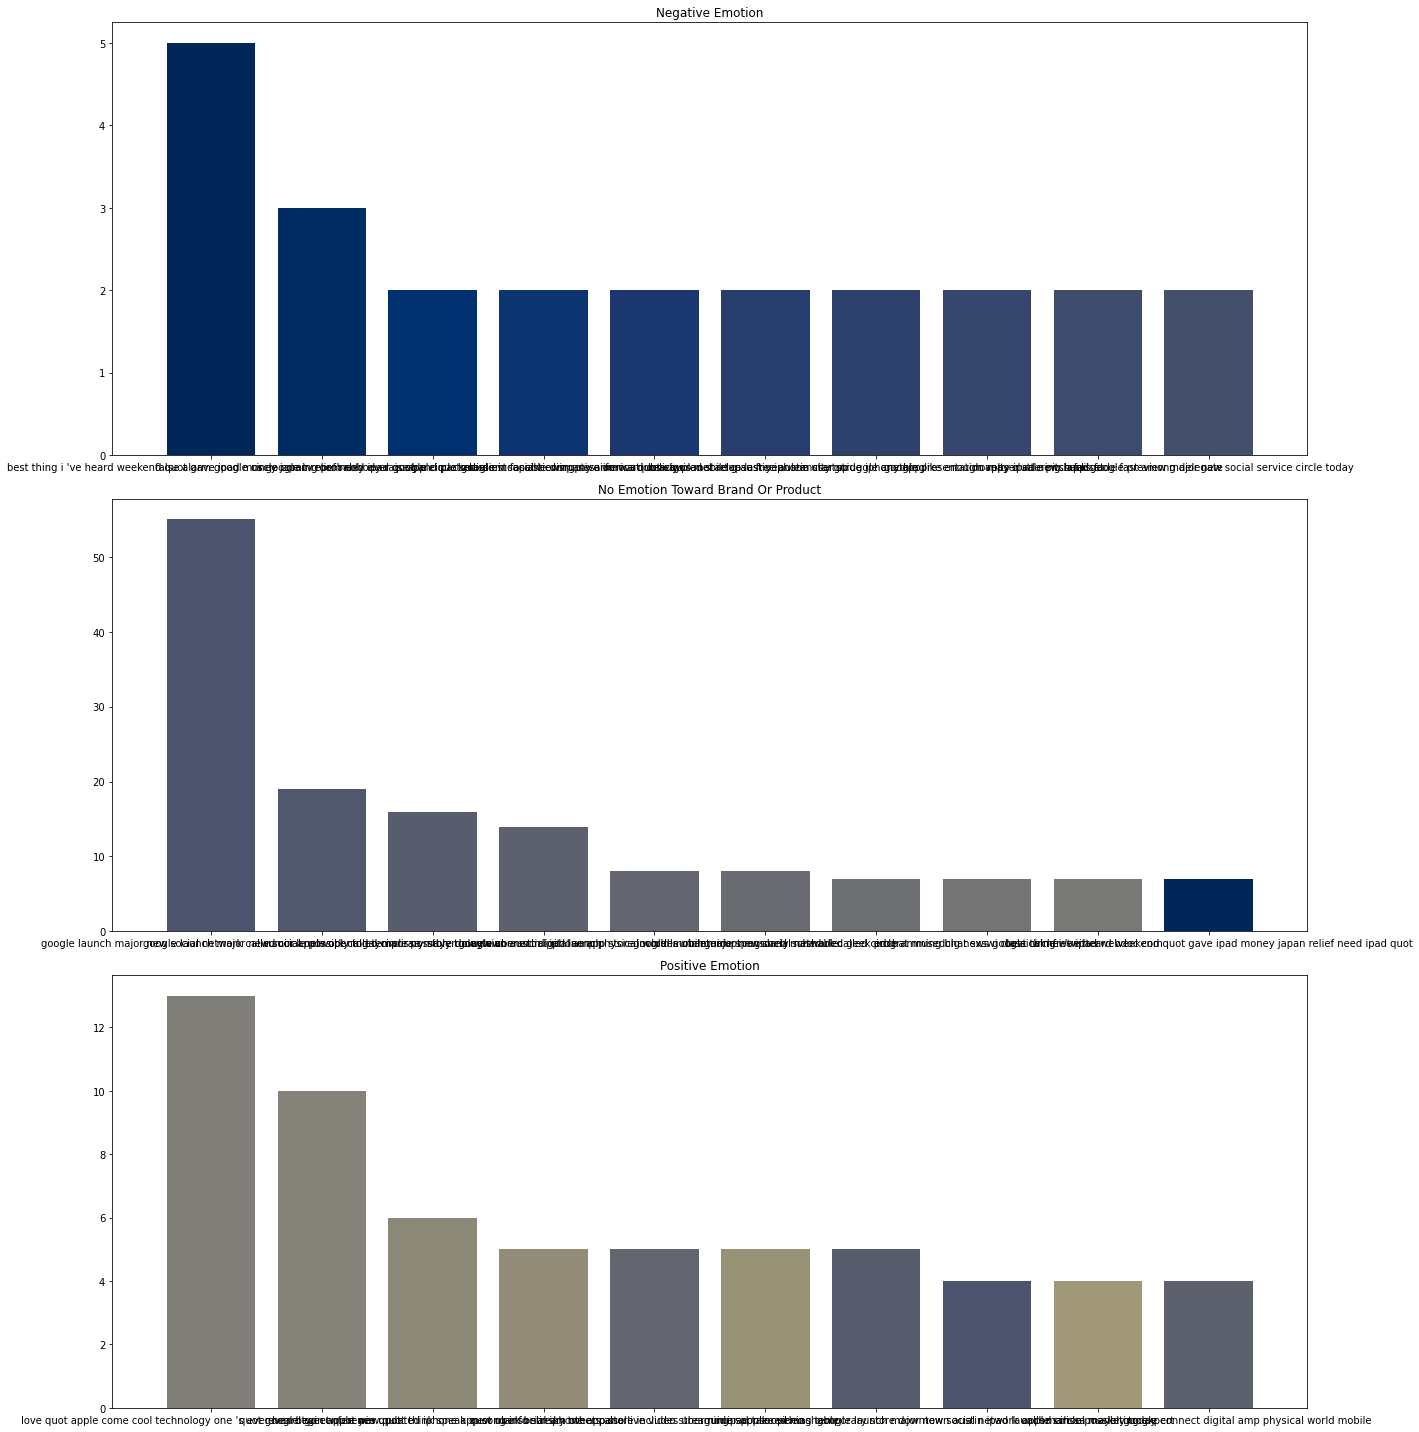

In [14]:
fig, axes = plt.subplots(nrows=3, figsize=(20, 20))

# Empty dictionary to hold words that have been plotted and their colors
plotted_words_and_colors = {}
# Choose a color palette
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique genre
data_by_sentiment = [y for _, y in df.groupby('is_there_an_emotion_directed_at_a_brand_or_product', as_index=False)]
for idx, sentiment_df in enumerate(data_by_sentiment):
    # Find top 10 words in this genre
    all_words_in_sentiment = sentiment_df.lemmatized_text.explode()
    top_10 = all_words_in_sentiment.value_counts()[:10]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
#    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(sentiment_df.iloc[0].is_there_an_emotion_directed_at_a_brand_or_product.title())
      
fig.tight_layout();

In [15]:
# Instantiate CountVectorizer
count_vectorizer = CountVectorizer()

# Use CountVectorizer on the lemmatized text
count_matrix = count_vectorizer.fit_transform(df['lemmatized_text'])

In [16]:
# Convert the count matrix to a DataFrame
count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names())

In [17]:
count_df.head()

,aapl,aaron,ab,abacus,abandoned,abba,abc,aber,ability,able,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Display the frequency table
freq_table = count_df.sum(axis=0).sort_values(ascending=False).reset_index()
freq_table.columns = ['Term', 'Frequency']
print(freq_table)

              Term  Frequency
0             ipad       2848
1           google       2501
2            apple       2184
3             quot       1582
4           iphone       1497
...            ...        ...
8078    presumably          1
8079    prettycool          1
8080  flairbuilder          1
8081           fjs          1
8082          zzzs          1

[8083 rows x 2 columns]


In [19]:
freq_table = count_df.sum(axis=0).sort_values(ascending=False).reset_index()
freq_table.columns = ['Term', 'Frequency']
print(freq_table[:30])

       Term  Frequency
0      ipad       2848
1    google       2501
2     apple       2184
3      quot       1582
4    iphone       1497
5     store       1437
6       new       1057
7    austin        922
8       amp        803
9       app        791
10   launch        666
11   circle        646
12   social        633
13    today        566
14  android        563
15      pop        546
16  network        455
17      get        439
18     line        429
19      via        400
20    party        381
21     free        378
22   called        353
23   mobile        344
24    sxswi        333
25      one        301
26    major        301
27     time        291
28     like        286
29      day        280


In [20]:
type(count_df)

pandas.core.frame.DataFrame

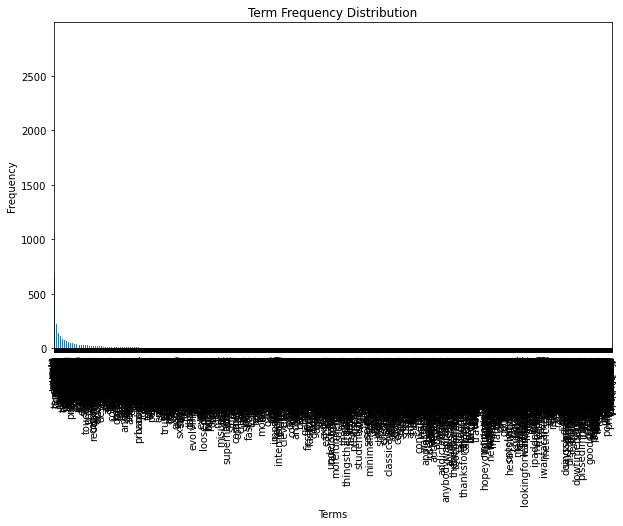

In [21]:
# Calculate term frequencies
term_frequencies = count_df.sum(axis=0)

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
term_frequencies.sort_values(ascending=False).plot(kind='bar')
plt.title('Term Frequency Distribution')
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.show()

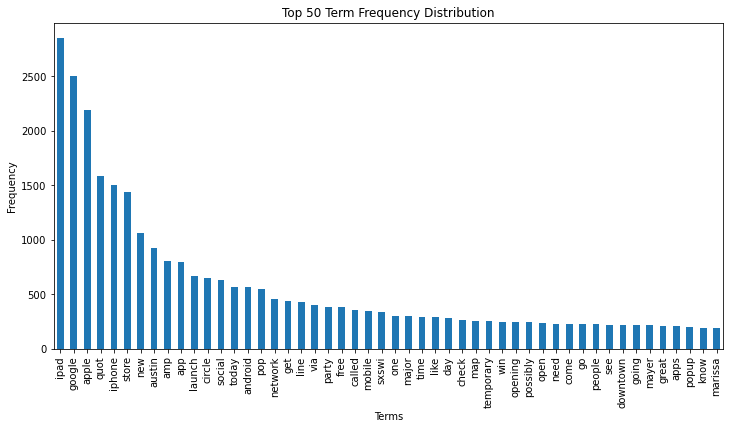

In [22]:
# top 50 terms selected
top_50_terms = term_frequencies.sort_values(ascending=False).head(50)

# Plot the top 50 terms in the frequency distribution
plt.figure(figsize=(12, 6))
top_50_terms.plot(kind='bar')
plt.title('Top 50 Term Frequency Distribution')
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.show()

In [23]:
top_50_terms

ipad         2848
google       2501
apple        2184
quot         1582
iphone       1497
store        1437
new          1057
austin        922
amp           803
app           791
launch        666
circle        646
social        633
today         566
android       563
pop           546
network       455
get           439
line          429
via           400
party         381
free          378
called        353
mobile        344
sxswi         333
one           301
major         301
time          291
like          286
day           280
check         259
map           256
temporary     254
win           249
opening       242
possibly      240
open          231
need          230
come          224
go            223
people        223
see           221
downtown      216
going         213
mayer         213
great         211
apps          210
popup         198
know          193
marissa       186
dtype: int64

In [24]:
print(f'There are {len(set(count_df))} unique lemmas.')

There are 8083 unique lemmas.


#### TF-IDF Vectorizer
First iteration
- default, besides using a token pattern that captures words with letters & words with & without contractions
- stopwords were removed 

Second iteration
- max_features updated to 4000

In [25]:
#TF-IDF vectorizer: content
tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw, max_features=4000)
tf = tf_vec.fit_transform(df.lemmatized_text)

tf_vec_df = pd.DataFrame(tf.toarray(), columns=tf_vec.get_feature_names())
tf_vec_df.head()

,aapl,aaron,ab,abacus,abba,abc,ability,able,abnormal,absolutely,...,zip,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
count_df.head()

,aapl,aaron,ab,abacus,abandoned,abba,abc,aber,ability,able,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_text,lemmatized_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,g iphone hrs tweeting rise austin dead need up...,g iphone hr tweeting rise austin dead need upg...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad also sale,wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year's festival crashy year's iphone app,hope year 's festival crashy year 's iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri marissa mayer google tim o'rei...,great stuff fri marissa mayer google tim o'rei...


In [28]:
X = count_df
y = df.is_there_an_emotion_directed_at_a_brand_or_product

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.3)

### Multinomial Naive Bayes

In [29]:
# instantiate multinomal naive bayes
mnb = MultinomialNB(alpha=.7)

mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.7)

In [30]:
# accuracy score on training & testing data
print(mnb.score(X_train, y_train))
print(mnb.score(X_test, y_test))

0.8318053008834806
0.6495527032283158


In [31]:
# precision score on training & testing data
# micro: treats all classes equally; preferred in class imbalances & multi-class problems
print(precision_score(y_train, mnb.predict(X_train), average='micro'))
print(precision_score(y_test, mnb.predict(X_test), average='micro'))

0.8318053008834806
0.6495527032283158


In [32]:
print(f1_score(y_train, mnb.predict(X_train), average='micro'))
print(f1_score(y_test, mnb.predict(X_test), average='micro'))

0.8318053008834806
0.6495527032283158


Original scores: 80.9% on training, 63.5% on testing
- max_features=4000: no change
- alpha = .7: accuracy = 65%
- alpha = .5: accuracy changed to 63.9%
- alpha = .1: 62.6%

''

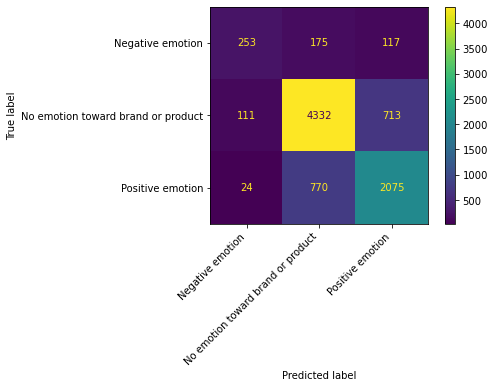

In [33]:
plot_confusion_matrix(mnb, X, y)
plt.xticks(rotation=45, ha="right")
;

In [34]:
# instantiate decision tree, random state of 42
dt = DecisionTreeClassifier(random_state=42, max_depth=25, min_samples_leaf=1, min_samples_split=5)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=25, min_samples_split=5, random_state=42)

In [35]:
# accuracy score on training & testing data
print(dt.score(X_train, y_train))
print(dt.score(X_test, y_test))
#overfit

0.7736289381563594
0.6553870089459354


In [36]:
# precision scores on training & data
# use 'micro' because multi-class classification, & imbalanced classes
print(precision_score(y_train, dt.predict(X_train), average='micro'))
print(precision_score(y_test, dt.predict(X_test), average='micro'))

0.7736289381563594
0.6553870089459354


In [37]:
# f1 scores on training & testing
print(f1_score(y_train, dt.predict(X_train), average='micro'))
print(f1_score(y_test, dt.predict(X_test), average='micro'))

0.7736289381563592
0.6553870089459354


Original scores: 95.9% training, 65% testing
max_features: 4000, max_depth=25, min_samples_split=5, random_state=42: 75.8% testing, 64.3% on test
- helped with overfitting

updated score: 77.4% training, 65.5% testing

''

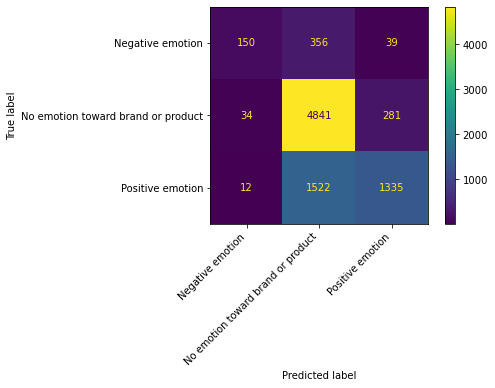

In [38]:
# confusion matrix for decision tree
plot_confusion_matrix(dt, X, y)
plt.xticks(rotation=45, ha="right")
;

### RandomForest

In [39]:
rf = RandomForestClassifier(random_state=42, min_samples_split=20, n_estimators=150)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=20, n_estimators=150, random_state=42)

In [40]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9179863310551759
0.691559704395177


In [41]:
print(precision_score(y_train, rf.predict(X_train), average='micro'))
print(precision_score(y_test, rf.predict(X_test), average='micro'))

0.9179863310551759
0.691559704395177


In [42]:
print(f1_score(y_train, rf.predict(X_train), average='micro'))
print(f1_score(y_test, rf.predict(X_test), average='micro'))

0.9179863310551759
0.691559704395177


- Original scores: 95.9% training, 66.5 on testing
- max_features: 4000, min_samples_split=20, n_estimators=150, random_state=42: 91.7% training, 67.8% on testing
- max_features: 4000, training = 91.8%, testing = 69.2%

''

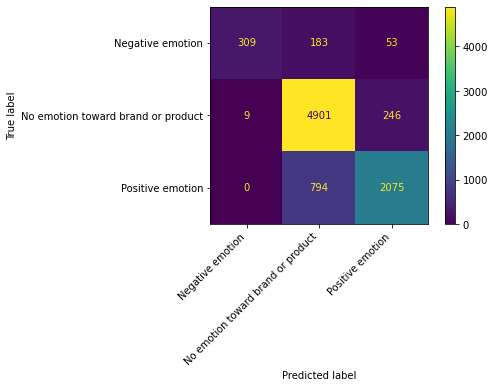

In [43]:
plot_confusion_matrix(rf, X, y)
plt.xticks(rotation=45, ha="right")
;

MNB was the best in terms of overfitting, but random forest did the best for testing data (~66.45% accuracy/precision)

#### Ensemble

In [47]:
# ensemble method for fun
ensemble = VotingClassifier(estimators=[
    ('tree', dt),
    ('rf', rf),
    ('nb', mnb)
], voting='hard')

ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=25,
                                                     min_samples_split=5,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(min_samples_split=20,
                                                     n_estimators=150,
                                                     random_state=42)),
                             ('nb', MultinomialNB())])

In [48]:
print(precision_score(y_train, ensemble.predict(X_train), average='micro'))
print(precision_score(y_test, ensemble.predict(X_test), average='micro'))

0.884314052342057
0.690781796966161


In [49]:
print(f1_score(y_train, ensemble.predict(X_train), average='micro'))
print(f1_score(y_test, ensemble.predict(X_test), average='micro'))

0.884314052342057
0.690781796966161


In [50]:
X.shape

(8570, 8083)

In [51]:
X_train.shape

(5999, 8083)

In [52]:
y.shape

(8570,)

In [53]:
y_train.shape

(5999,)

## Hyperparameter tweaking

In [58]:
# Tuning the decision tree, dt

# Parameter grid defined for search
param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# start timer
start_time_dt = time.time()

# Create the GridSearchCV object
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, n_jobs=8)

# Fit the grid search to data
grid_search_dt.fit(X_train, y_train)

# stop timer & calculate time
end_time_dt = time.time()
total_time_dt = end_time_dt - start_time_dt

# Print best parameters & score
print("Grid Search Time: {:.2f} seconds".format(total_time_dt))
print("Best Parameters: ", grid_search_dt.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search_dt.best_score_))

Grid Search Time: 353.72 seconds
Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Cross-Validation Score: 0.64


In [63]:
# Tuning the decision tree, dt, again
# Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}

# Parameter grid defined for search
param_grid_dt2 = {
    'max_depth': [15, 20, 25],
    'min_samples_leaf': [0, 1, 2], 
    'min_samples_split': [4, 5, 6]
}

# start timer
start_time_dt2 = time.time()

# Create the GridSearchCV object
grid_search_dt2 = GridSearchCV(dt, param_grid_dt2, cv=5, n_jobs=8)

# Fit the grid search to data
grid_search_dt2.fit(X_train, y_train)

# stop timer & calculate time
end_time_dt2 = time.time()
total_time_dt2 = end_time_dt2 - start_time_dt2

# Print best parameters & score
print("Grid Search Time: {:.2f} seconds".format(total_time_dt2))
print("Best Parameters: ", grid_search_dt2.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search_dt2.best_score_))

Grid Search Time: 232.52 seconds
Best Parameters:  {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Cross-Validation Score: 0.64


In [73]:
# Tuning the decision tree, dt, again
# Best Parameters:  {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 5}

# Parameter grid defined for search
param_grid_dt3 = {
    'max_depth': [20, 25, 30, None],
    'min_samples_leaf': [0, 1, 2], 
    'min_samples_split': [4, 5, 6]
}

# start timer
start_time_dt3 = time.time()

# Create the GridSearchCV object
grid_search_dt3 = GridSearchCV(dt, param_grid_dt3, cv=5, n_jobs=8)

# Fit the grid search to data
grid_search_dt3.fit(X_train, y_train)

# stop timer & calculate time
end_time_dt3 = time.time()
total_time_dt3 = end_time_dt3 - start_time_dt3

# Print best parameters & score
print("Grid Search Time: {:.2f} seconds".format(total_time_dt3))
print("Best Parameters: ", grid_search_dt3.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search_dt3.best_score_))

Grid Search Time: 374.50 seconds
Best Parameters:  {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Cross-Validation Score: 0.64


In [59]:
# Tuning the random forest, rf

# Parameter grid defined
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# start timer
start_time_rf = time.time()

# GridSearchCV object created for rf
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=8)

# Fit to data
grid_search_rf.fit(X_train, y_train)

# stop timer & caluclate time
end_time_rf = time.time()
total_time_rf = end_time_rf - start_time_rf

# Print time & best parameters/score
print("Grid Search Time: {:.2f} seconds".format(total_time_rf))
print("Best Parameters: ", grid_search_rf.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search_rf.best_score_))

Grid Search Time: 3130.64 seconds
Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Score: 0.67


In [74]:
# Tuning the random forest, rf, again

# Parameter grid defined
param_grid_rf2 = {
    'n_estimators': [75, 100, 150],
    'max_depth': [None, 20, 30],
    'min_samples_split': [7, 10, 13],
    'min_samples_leaf': [1, 2, 3]
}

# start timer
start_time_rf2 = time.time()

# GridSearchCV object created for rf
grid_search_rf2 = GridSearchCV(rf, param_grid_rf2, cv=5, n_jobs=8)

# Fit to data
grid_search_rf2.fit(X_train, y_train)

# stop timer & caluclate time
end_time_rf2 = time.time()
total_time_rf2 = end_time_rf2 - start_time_rf2

# Print time & best parameters/score
print("Grid Search Time: {:.2f} seconds".format(total_time_rf2))
print("Best Parameters: ", grid_search_rf2.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search_rf2.best_score_))

Grid Search Time: 3243.79 seconds
Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Score: 0.67


In [75]:
best_rf2_model = grid_search_rf2.best_estimator_
feature_importances = best_rf2_model.feature_importances_
print("best estimator: ", best_rf2_model)
print("Feature importances: ", feature_importances)

best estimator:  RandomForestClassifier(min_samples_split=10, random_state=42)
Feature importances:  [3.54859228e-04 0.00000000e+00 8.30290436e-06 ... 1.42314512e-05
 4.54501132e-07 6.21120131e-05]


- consider 'max_features' : ['', '', ''], 'min_weight_fraction_leaf': [0.0, 0.1, 0.2], 'ccp_alpha'
> best_rf_model = grid_search.best_estimator_
>
>feature_importances = best_rf_model.feature_importances_

In [76]:
# Tuning the random forest, rf, again

# Parameter grid defined
param_grid_rf3 = {
    'n_estimators': [100, 150],
    'max_depth': [None, 500, 1000],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [1, 2]
}

# start timer
start_time_rf3 = time.time()

# GridSearchCV object created for rf
grid_search_rf3 = GridSearchCV(rf, param_grid_rf3, cv=5, n_jobs=8)

# Fit to data
grid_search_rf3.fit(X_train, y_train)

# stop timer & calculate time
end_time_rf3 = time.time()
total_time_rf3 = end_time_rf3 - start_time_rf3

# Print time & best parameters/score
print("Grid Search Time: {:.2f} seconds".format(total_time_rf3))
print("Best RF Model: ", grid_search_rf3.best_estimator_)
print("Best Parameters: ", grid_search_rf3.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search_rf2.best_score_))

Grid Search Time: 2145.60 seconds
Best RF Model:  RandomForestClassifier(min_samples_split=20, n_estimators=150, random_state=42)
Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 150}
Best Cross-Validation Score: 0.67


In [77]:
best_rf3_model = grid_search_rf3.best_estimator_
feature_importances3 = best_rf3_model.feature_importances_
print("best estimator: ", best_rf3_model)
print("Feature importances: ", feature_importances3)

best estimator:  RandomForestClassifier(min_samples_split=20, n_estimators=150, random_state=42)
Feature importances:  [4.10428151e-04 6.95195268e-08 2.75064879e-06 ... 3.81654902e-06
 1.11857563e-05 4.28357709e-05]


In [61]:
# Tuning the ensemble method (mnb, rf, dt)
# Define the ensemble using a VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[
    ('mnb', mnb),
    ('dt', dt),
    ('rf', rf)
], voting='hard')

# Define the parameter grid to search
param_grid = {
    'mnb__alpha': [0.1, 0.5, 1.0],
    'dt__max_depth': [None, 10, 20],
    'dt__min_samples_split': [2, 5, 10],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# start timer
start_time_ens = time.time()

# Create the GridSearchCV object
grid_search_ensemble = GridSearchCV(ensemble_classifier, param_grid, cv=5, n_jobs=9)

# Fit the grid search to your data
grid_search_ensemble.fit(X_train, y_train)

# stop timer & calculate time
end_time_ens = time.time()
total_time_ens = end_time_ens - start_time_ens

# Print the best parameters and best score
print("Grid Search Time: {:.2f} seconds".format(total_time_ens))
print("Best Parameters: ", grid_search_ensemble.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search_ensemble.best_score_))

KeyboardInterrupt: 